M3. Improve BoVW with SVM's
--

In [1]:
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from utils.CodeTimer import CodeTimer
from utils.DatasetManager import DatasetManager
from utils.Normalizer import Normalizer as Normalizer_
from descriptors.SIFT import DenseSIFT as DenseSIFT_
from descriptors.SIFT import DenseSIFTPyramid 
from descriptors.VisualWords import VisualWords as VisualWords_
from descriptors.VisualWords import VisualWordsPyramid 
from utils.Kernels import histogram_intersection_kernel
from fishervector import FisherVectorGMM

From previous week, we found that using the following parameters we obtained a precision for the test around 81.16%.

   1. Vocabulary of 128
   2. Bray Curtis Distance
   3. Dense Sift using 8 as the step and the size of the keypoints.
   4. Use LDA with 7 features.
   
This week we will try to increase this precision by using SVM. To do so we will study the following

   1. First of all, a suggestion from last activity was to mix different scales of the DenseSIFT descriptors. We tried to change the steps and the sizes a bit but selecting the same number for the step and size gave us in the end the best result. 
   
   2. Change the Vocabulary size or also known as number of clusters of the VisualWords.
   3. See how Normalization affects the results.
   4. Finetuning the SVM
   5. See if using a pyramid strategy improves the previous results
   6. Trying Fisher Vectors

In [2]:
dataset = DatasetManager('../Databases/MIT_split')
train_img_paths, train_labels, test_img_paths, test_labels = dataset.load_dataset()
SAVE_PATH = '../SavePath/'

In [11]:
print(len(train_desc))

1881


Change the size of the DenseSIFT
--

In this experiment we will fix the vocabulary size, and we will only change the step and try different sizes of the DenseSIFT descriptors. In addition we will substitute the KNN with a SVM. We will also eliminate the LDA. 

In [6]:
N_CLUSTERS = 128
K_FOLDS = 5
PARAM_GRID = {'C': [1], 'kernel': ['rbf'], 'gamma': ['scale']}
step_sizes = [8, 16, 32]
descriptor_sizes_dict = {8: [[1],[0.5,1]], 16: [[1],[0.5,1],[0.25,0.5,0.75,1]], 32: [[1],[0.5,1],[0.25,0.5,0.75,1]]}
results_test = []
results_train = []

DenseSIFT = DenseSIFT_()
VisualWords = VisualWords_(N_CLUSTERS)
for step_size in step_sizes:
    for descriptor_sizes_ in descriptor_sizes_dict[step_size]:
        # Define descriptor sizes
        descriptor_sizes = sorted(list(set([int(i*step_size) for i in descriptor_sizes_])))
        train_desc_path = SAVE_PATH+'desc'+os.sep+'train'+str(N_CLUSTERS)+'_'+str(step_size)+'_'+'-'.join([str(i) for i in descriptor_sizes])+'.dat'
        test_desc_path = SAVE_PATH+'desc'+os.sep+'test'+str(N_CLUSTERS)+'_'+str(step_size)+'_'+'-'.join([str(i) for i in descriptor_sizes])+'.dat'
        train_data_path = SAVE_PATH+'data'+os.sep+'train'+str(N_CLUSTERS)+'_'+str(step_size)+'_'+'-'.join([str(i) for i in descriptor_sizes])+'.dat'
        test_data_path = SAVE_PATH+'data'+os.sep+'test'+str(N_CLUSTERS)+'_'+str(step_size)+'_'+'-'.join([str(i) for i in descriptor_sizes])+'.dat'
        if all(os.path.isfile(path) for path in [train_desc_path,test_desc_path,train_data_path,test_data_path]):
            train_desc = pickle.load(open(train_desc_path, 'rb'))
            test_desc = pickle.load(open(test_desc_path,'rb'))
            train_data = pickle.load(open(train_data_path,'rb'))
            test_data = pickle.load(open(test_data_path,'rb'))
        else:
            with CodeTimer("Obtain training and test data"):
                # Compute DenseSIFT descriptors for train and test sets
                train_desc = DenseSIFT.compute(train_img_paths, step_size, descriptor_sizes)
                test_desc = DenseSIFT.compute(test_img_paths, step_size, descriptor_sizes)
                # Save computed data
                pickle.dump(train_desc, open(train_desc_path, 'wb'))
                pickle.dump(test_desc, open(test_desc_path, 'wb'))
                # Obtain visual words for train and test sets
                VisualWords.fit(train_desc)
                train_data = VisualWords.get_visual_words(train_desc)
                test_data = VisualWords.get_visual_words(test_desc)
                # Save computed data
                pickle.dump(train_data, open(train_data_path, 'wb'))
                pickle.dump(test_data, open(test_data_path, 'wb'))
                # Train SVM with cross-validation 5-fold
        with CodeTimer("Train SVM"):
            cv = GridSearchCV(SVC(), param_grid=PARAM_GRID, cv=K_FOLDS)
            cv.fit(train_data, train_labels)
        # Test SVM
        with CodeTimer("Test SVM"):
            results_train.append(cv.score(train_data, train_labels))
            results_test.append(cv.score(test_data, test_labels))

Train SVM: 2.523352861404419 s
Test SVM: 0.18150997161865234 s
Obtain training and test data: 306.0814678668976 s
Train SVM: 2.12414288520813 s
Test SVM: 0.18492579460144043 s
Obtain training and test data: 176.2810640335083 s
Train SVM: 1.9751551151275635 s
Test SVM: 0.15711688995361328 s
Obtain training and test data: 216.36603903770447 s
Train SVM: 2.1164751052856445 s
Test SVM: 0.17260003089904785 s
Obtain training and test data: 314.469685792923 s
Train SVM: 1.8273940086364746 s
Test SVM: 0.1612539291381836 s
Obtain training and test data: 111.42421984672546 s
Train SVM: 2.0699920654296875 s
Test SVM: 0.1585249900817871 s
Obtain training and test data: 145.2274830341339 s
Train SVM: 1.9113810062408447 s
Test SVM: 0.15057086944580078 s
Obtain training and test data: 218.12727189064026 s
Train SVM: 1.8377351760864258 s
Test SVM: 0.16202020645141602 s


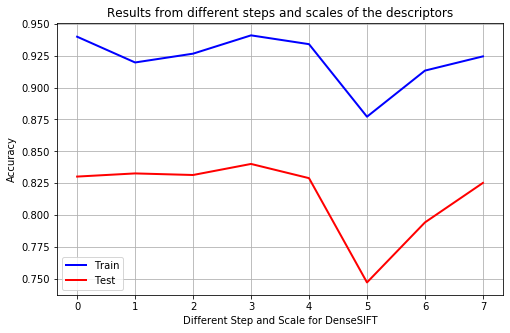

In [27]:
plt.figure(figsize=(8, 5))
plt.title('Results from different steps and scales of the descriptors')
plt.plot(results_train,'b',linewidth=2,label='Train')
plt.plot(results_test,'r',linewidth=2,label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Different Step and Scale for DenseSIFT')
plt.legend()
plt.grid(True)
plt.show()

To explain this graph we have tried for different step sizes different sizes. So for the steps we have tried 8,16 and 32. Then for each one we have tried the scales to be first the same as the step, then adding $\frac{step}{2}$ and finally adding $\frac{3 \cdot step}{4}$ and $\frac{step}{4}$.  

We present here the X Axis:

0. Step: 8 -- Scales: 8
1. Step: 8 -- Scales: 4-8
2. Step: 16 -- Scales: 16
3. Step: 16 -- Scales: 8-16
4. Step: 16 -- Scales: 4-8-12-16
5. Step: 32 -- Scales: 32
6. Step: 32 -- Scales: 16-32
7. Step: 32 -- Scales: 8-16-24-32

Conclusion: 

As the graph shows using small step size generally works better than taking big step sizes. Then taking different scales we see that tends to improve the results. For computation cost we have decided to use a step size of 16 and scales of 8 and 16 for our descriptors.

We also see a consistent difference between the train accuracy and the test accuracy, which seems to us that could be reduced when taking into account the regularization parameter of the SVM.

Change the number of Clusters or the Vocabulary size
--

For this experiment now we will try different number of clusters

In [19]:
STEP_SIZE = 16
DESC_SIZE = [8,16]
N_CLUSTERS = [128, 256, 384, 512, 640, 768, 896, 1024]
results_test = []
results_train = []

DenseSIFT = DenseSIFT_()
for n_cluster in N_CLUSTERS:
    VisualWords = VisualWords_(n_cluster)
    train_desc_path = SAVE_PATH+'desc'+os.sep+'train'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    test_desc_path = SAVE_PATH+'desc'+os.sep+'test'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    train_data_path = SAVE_PATH+'data'+os.sep+'train'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    test_data_path = SAVE_PATH+'data'+os.sep+'test'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    if all(os.path.isfile(path) for path in [train_desc_path,test_desc_path,train_data_path,test_data_path]):
        train_desc = pickle.load(open(train_desc_path, 'rb'))
        test_desc = pickle.load(open(test_desc_path,'rb'))
        train_data = pickle.load(open(train_data_path,'rb'))
        test_data = pickle.load(open(test_data_path,'rb'))
    else:
        with CodeTimer("Obtain training and test data"):
            # Compute DenseSIFT descriptors for train and test sets
            train_desc = DenseSIFT.compute(train_img_paths, STEP_SIZE, DESC_SIZE)
            test_desc = DenseSIFT.compute(test_img_paths, STEP_SIZE, DESC_SIZE)
            # Save computed data
            pickle.dump(train_desc, open(train_desc_path, 'wb'))
            pickle.dump(test_desc, open(test_desc_path, 'wb'))
            # Obtain visual words for train and test sets
            VisualWords.fit(train_desc)
            train_data = VisualWords.get_visual_words(train_desc)
            test_data = VisualWords.get_visual_words(test_desc)
            # Save computed data
            pickle.dump(train_data, open(train_data_path, 'wb'))
            pickle.dump(test_data, open(test_data_path, 'wb'))
            # Train SVM with cross-validation 5-fold
    with CodeTimer("Train SVM"):
        cv = GridSearchCV(SVC(), param_grid=PARAM_GRID, cv=K_FOLDS)
        cv.fit(train_data, train_labels)
    # Test SVM
    with CodeTimer("Test SVM"):
        results_train.append(cv.score(train_data, train_labels)) 
        results_test.append(cv.score(test_data, test_labels)) 

Obtain training and test data: 40.542662143707275 s
Train SVM: 2.670769214630127 s
Test SVM: 0.20858502388000488 s
Obtain training and test data: 53.31530809402466 s
Train SVM: 5.075722932815552 s
Test SVM: 0.4352397918701172 s
Obtain training and test data: 72.8689751625061 s
Train SVM: 7.793022871017456 s
Test SVM: 0.6836180686950684 s
Obtain training and test data: 117.54529309272766 s
Train SVM: 10.785996198654175 s
Test SVM: 0.8818421363830566 s
Obtain training and test data: 183.32933926582336 s
Train SVM: 13.98125410079956 s
Test SVM: 1.1225290298461914 s
Obtain training and test data: 243.6653392314911 s
Train SVM: 17.40980315208435 s
Test SVM: 1.5564053058624268 s
Obtain training and test data: 300.5999069213867 s
Train SVM: 20.803389072418213 s
Test SVM: 1.5164148807525635 s
Obtain training and test data: 355.8561749458313 s
Train SVM: 24.697921991348267 s
Test SVM: 1.8541321754455566 s


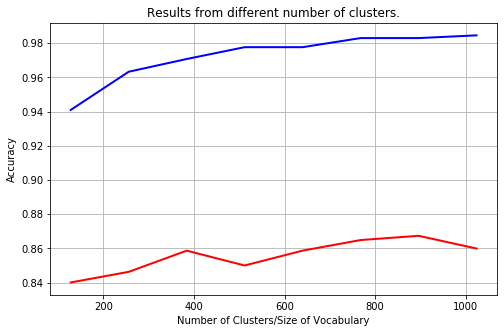

In [29]:
plt.figure(figsize=(8, 5))
plt.title('Results from different number of clusters.')
plt.plot(N_CLUSTERS,results_train,'b',linewidth=2,label='Test')
plt.plot(N_CLUSTERS,results_test,'r',linewidth=2,label='Train')
plt.ylabel('Accuracy')
plt.xlabel('Number of Clusters/Size of Vocabulary')
plt.grid(True)
plt.show()

Conclusion:
    
In this graph we can appreciate that using now more clusters helps the SVM to increase the accuracy from 81.16% to more than 86% (86.74% to be exact) which is great. Until this point we have been using the default parameters of the SVM which are:

1. C -- (Regularization parameter): 1
2. kernel -- (Specifies the kernel): RBF
3. gamma -- (Kernel coefficient): scale
5. decision_function_shape -- (Whether to return a one-vs-rest or other settings): ovr

How Normalization affects the results
--

In this experiment we are going to normalize the data and then see if the normalization actually improves the results versus not applying it. We will try 3 types of normalizations:
   1. L1
   2. L2
   3. Power
   
Apart from these normalizations we will also normalize in mean and variance the data using a class from sklearn call _Standard Scalar_

In [9]:
N_CLUSTERS = 896
STEP_SIZE = 16
DESC_SIZE = [8,16]
K_FOLDS = 5
PARAM_GRID = {'C': [1], 'kernel': ['rbf'], 'gamma': ['scale']}
NORMALIZATIONS = ["l1","l2","power"]

In [10]:
results_train = []
results_test = []

DenseSIFT = DenseSIFT_()
scaler = StandardScaler()
VisualWords = VisualWords_(N_CLUSTERS)
Normalizer = Normalizer_()

train_desc_path = SAVE_PATH+os.sep+'desc'+os.sep+'train'+str(N_CLUSTERS)+'_'+str(STEP_SIZE)+'_8-16.dat'
test_desc_path = SAVE_PATH+os.sep+'desc'+os.sep+'test'+str(N_CLUSTERS)+'_'+str(STEP_SIZE)+'_8-16.dat'
train_data_path = SAVE_PATH+os.sep+'data'+os.sep+'train'+str(N_CLUSTERS)+'_'+str(STEP_SIZE)+'_8-16.dat'
test_data_path = SAVE_PATH+os.sep+'data'+os.sep+'test'+str(N_CLUSTERS)+'_'+str(STEP_SIZE)+'_8-16.dat'
if all(os.path.isfile(path) for path in [train_desc_path,test_desc_path,train_data_path,test_data_path]):
    train_desc = pickle.load(open(train_desc_path, 'rb'))
    test_desc = pickle.load(open(test_desc_path,'rb'))
    train_data = pickle.load(open(train_data_path,'rb'))
    test_data = pickle.load(open(test_data_path,'rb'))
else:
    with CodeTimer("Obtain training and test data"):
        # Compute DenseSIFT descriptors for train and test sets
        train_desc = DenseSIFT.compute(train_img_paths, STEP_SIZE, DESC_SIZE, 2)
        test_desc = DenseSIFT.compute(test_img_paths, STEP_SIZE, DESC_SIZE, 2)
        # Save computed data
        pickle.dump(train_desc, open(train_desc_path, 'wb'))
        pickle.dump(test_desc, open(test_desc_path, 'wb'))
        # Obtain visual words for train and test sets
        VisualWords.fit(train_desc)
        train_data = VisualWords.get_visual_words(train_desc)
        test_data = VisualWords.get_visual_words(test_desc)
        # Save computed data
        pickle.dump(train_data, open(train_data_path, 'wb'))
        pickle.dump(test_data, open(test_data_path, 'wb'))
for norm in NORMALIZATIONS:
    # Normalize data
    train_data_norm = Normalizer.normalize(train_data, norm)
    test_data_norm = Normalizer.normalize(test_data, norm)
    # Scale data
    train_data_norm = scaler.fit_transform(train_data_norm)
    test_data_norm = scaler.transform(test_data_norm)
    # Train SVM with cross-validation 5-fold
    with CodeTimer("Train SVM"):
        cv = GridSearchCV(SVC(), param_grid=PARAM_GRID, cv=K_FOLDS)
        cv.fit(train_data_norm, train_labels)
    # Test SVM
    with CodeTimer("Test SVM"):
        results_train.append(cv.score(train_data_norm, train_labels)) 
        results_test.append(cv.score(test_data_norm, test_labels))

Train SVM: 28.611683130264282 s
Test SVM: 5.206831932067871 s
Train SVM: 27.188402891159058 s
Test SVM: 5.178617238998413 s
Train SVM: 28.08722472190857 s
Test SVM: 5.254977703094482 s


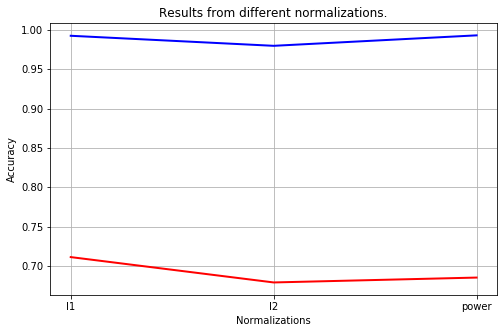

In [11]:
plt.figure(figsize=(8, 5))
plt.title('Results from different normalizations.')
plt.plot(NORMALIZATIONS,results_train,'b',linewidth=2,label='Test')
plt.plot(NORMALIZATIONS,results_test,'r',linewidth=2,label='Train')
plt.ylabel('Accuracy')
plt.xlabel('Normalizations')
plt.grid(True)
plt.show()

Conclusions: 

Observing this graph we can see that the L1 normalization seems to work better than the other normalizations. However, we see a significant drop in performance compared with previous test. We have to be careful because this test has been computed using the vanilla SVM, so maybe adjusting the SVM we achieve to improve the results, so from here L1 normalization will be applied.

Finetuning the SVM
--

To finetune the SVM we have three main parameters to test:

1. C: Regularizer constant
2. Kernel: type of kernel used
3. tol: Tolerance, value to adjust the level of tolerance on accepting errors.

For the C we will try low, mid and high values using a logarithmic scale. For the tolerance we will use values between 0 and 1. Finally for the kernels we will be using the default 'rbf', 'linear', 'sigmoid' and our implementation of the ***histogram intersection kernel***:  

```python
def histogram_intersection_kernel(a, b):
    K = np.empty(shape=(a.shape[0], b.shape[0]), dtype=np.float32)
    for i in range(a.shape[0]):
        K[i] = np.sum(np.minimum(a[i], b), axis=1)
    return K
```

In [8]:
N_CLUSTERS = 896
STEP_SIZE = 16
DESC_SIZE = [8,16]
K_FOLDS = 5
C = np.logspace(-4,4,15,base=10).tolist()
TOLERANCE = np.logspace(-3,3,10,base=2).tolist()

In [18]:
DenseSIFT = DenseSIFT_()
scaler = StandardScaler()
VisualWords = VisualWords_(N_CLUSTERS)
train_desc_path = SAVE_PATH+'desc'+os.sep+'train_exp_2.dat'
test_desc_path = SAVE_PATH+'desc'+os.sep+'test_exp_2.dat'
train_data_path = SAVE_PATH+'data'+os.sep+'train_exp_2.dat'
test_data_path = SAVE_PATH+'data'+os.sep+'test_exp_2.dat'
with CodeTimer("Obtain training and test data"):
    # Check for existing data files already computed
    if all(os.path.isfile(path) for path in [train_data_path, test_data_path, train_desc_path, test_desc_path]):
        train_data = pickle.load(open(train_data_path, 'rb'))
        test_data = pickle.load(open(test_data_path, 'rb'))
        train_desc = pickle.load(open(train_data_path, 'rb'))
        test_desc = pickle.load(open(test_data_path, 'rb'))
        train_data = scaler.fit_transform(train_data)
        test_data = scaler.transform(test_data)
    else:
        # Compute DenseSIFT descriptors for train and test sets
        train_desc = DenseSIFT.compute(train_img_paths, STEP_SIZE, DESC_SIZE)
        test_desc = DenseSIFT.compute(test_img_paths, STEP_SIZE, DESC_SIZE)
        # Save computed data
        pickle.dump(train_desc, open(train_desc_path, 'wb'))
        pickle.dump(test_desc, open(test_desc_path, 'wb'))
        # Obtain visual words for train and test sets
        VisualWords.fit(train_desc)
        train_data = VisualWords.get_visual_words(train_desc)
        test_data = VisualWords.get_visual_words(test_desc)
        # Save computed data
        pickle.dump(train_data, open(train_data_path, 'wb'))
        pickle.dump(test_data, open(test_data_path, 'wb'))

results_train = []
results_test = []
C = np.logspace(-4,4,15,base=10).tolist()
GAMMA = ['scale']
KERNEL = [histogram_intersection_kernel]
TOLERANCE = np.logspace(-3,0,10,base=2).tolist()
for c in C:
    # Normalize data
    train_data_norm = Normalizer.normalize(train_data, 'l1')
    test_data_norm = Normalizer.normalize(test_data, 'l1')
    # Scale data
    train_data_norm = scaler.fit_transform(train_data_norm)
    test_data_norm = scaler.transform(test_data_norm)
    PARAMETERS = {'C':[c],'gamma':GAMMA,'kernel':KERNEL,'tol': TOLERANCE}
    # Train SVM with cross-validation 5-fold
    with CodeTimer("Train SVM"):
        cv = GridSearchCV(SVC(), param_grid=PARAMETERS, cv=K_FOLDS, verbose=5, n_jobs=-1)
        cv.fit(train_data_norm, train_labels)
    # Test SVM
    with CodeTimer("Test SVM"):
        results_train.append(cv.score(train_data_norm, train_labels)) 
        results_test.append(cv.score(test_data_norm, test_labels)) 

Obtain training and test data: 0.06606698036193848 s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   24.4s remaining:   36.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s finished


Train SVM: 50.78174805641174 s
0.9782030834662414
0.8661710037174721
Test SVM: 20.63075089454651 s


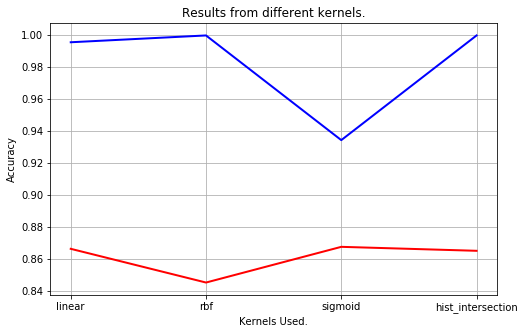

In [23]:
KERNEL = ["linear", "rbf", "sigmoid", "hist_intersection"]
plt.figure(figsize=(8, 5))
plt.title('Results from different kernels.')
plt.plot(KERNEL,results_train,'b',linewidth=2,label='Test')
plt.plot(KERNEL,results_test,'r',linewidth=2,label='Train')
plt.ylabel('Accuracy')
plt.xlabel('Kernels Used')
plt.grid(True)
plt.show()

Seeing this graph we can see that 'rbf' is the only one that works slighty worst than the others. We also see that using sigmoid, th SVM tend to not overfit as much as when other kernels are used.

For the following test, we will stay with sigmoid and histogram_intersection as both seem to work well and achieve accuracies around 86%

We need to remark that when using histogram_intersection, the parameter gamma is not used.

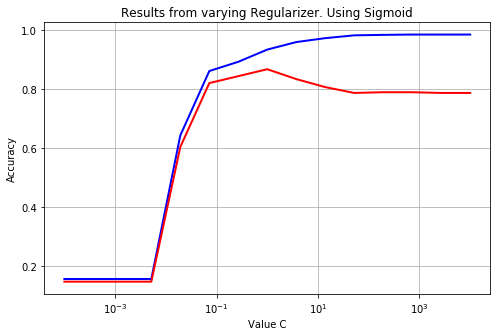

In [27]:
plt.figure(figsize=(8, 5))
plt.title('Results from varying Regularizer. Using Sigmoid')
plt.plot(C,results_train,'b',linewidth=2,label='Test')
plt.plot(C,results_test,'r',linewidth=2,label='Train')
plt.xscale('log',basex=10)
plt.ylabel('Accuracy')
plt.xlabel('Value C')
plt.grid(True)
plt.show()

When using the sigmoid kernel and playing with the regularizer value C, we see that taking a very low value does not help the SVM, meaning that instead of actually regularizing, don't allow the SVM to learn properly. Taking values too high, the accuracy increases but we see that given a point, choosing a higher regularization don't affect the model.

The conclusion is that using sigmoid kernel, C needs to be adjusted around 1 and 3.72 reaching then accuracies that get to 87%

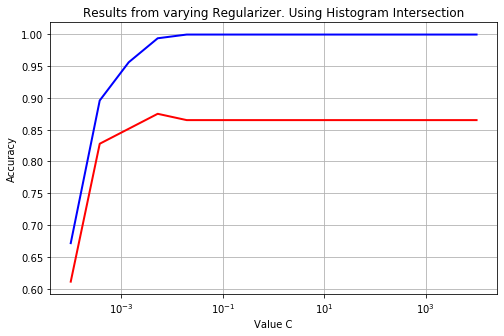

In [29]:
plt.figure(figsize=(8, 5))
plt.title('Results from varying Regularizer. Using Histogram Intersection')
plt.plot(C,results_train,'b',linewidth=2,label='Test')
plt.plot(C,results_test,'r',linewidth=2,label='Train')
plt.xscale('log',basex=10)
plt.ylabel('Accuracy')
plt.xlabel('Value C')
plt.grid(True)
plt.show()

When using the histogram_intersection and varying the value C, we see a similar behaviour as before with the sigmoid but more indicative. Values too low don't help but choosing it too high, is irrelevant and has no effect at all.

If choosing histogram_intersection C value needs to be adjusted around 0.001389 achieving then accuracies around 87%.

Seeing that both kernels (sigmoid and histogram_intersection) perform roughly similar, we have decided to stick with the histogram_intersection kernel.

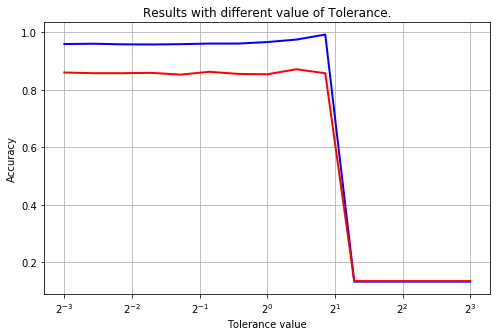

In [16]:
plt.figure(figsize=(8, 5))
plt.title('Results with different value of Tolerance.')
plt.plot(TOLERANCE,results_train,'b',linewidth=2,label='Test')
plt.plot(TOLERANCE,results_test,'r',linewidth=2,label='Train')
plt.xscale('log',basex=2)
plt.ylabel('Accuracy')
plt.xlabel('Tolerance value')
plt.grid(True)
plt.show()

When playing with tolerance we see that it is important not to choose a tolerance taht is too high. Makes sense because as bigger tolerance gets, the allowed error will be bigger, decreasing the accuracy. However we exepected to see a different behaviour for lower values of the tolerance, mainly because with different acceptance on the error we thought that different accuracies would be achieved. Instead we see that the tolerance is indiferent as long as it takes values lower than 2. It is true that choosing a value between 1 and 1.81 seems to have a slightly improvement reaching the 87.4%

Conclusions: 

We have seen that finetuning the SVM parameters have not improved a lot the basic vanilla SVM, passing from a 86.74% to numbers that barely surpass the 87% of accuracy (best 87.67%). The best approach seems to be the following:

1. 896 Clusters or Number of words.
2. Dense sift of 16 steps and sizes of 8 and 16
3. Normalization with l1
4. Using the histogram_intersection Kernel
5. Using values of C around 0.001389

In the following parts we will study if considereing the problem differently the results can be improved as we don't conform with that low improvement.

Pyramid Dense SIFT
--

So far we have tried try different ways of computing the data and finetune the SVM. This time we want to change if applying apyramidal structure on the data could imporve our results of what we have seen.

The implementation of the Pyramid Dense SIFT computes the SIFT descriptors in subparts of the image. So we divide the image in equal parts and then compute the DenseSIFT on each part. We consider that 4 parts is enough, as more than that, could generate to much descriptors distorting the results.

For this experiment we study again how many clusters the VisualWords needs (Which has to be changed due to the change on the descriptors). We are interested in testing if the pyramidal SIFT changes the previous parameters.

In [14]:
STEP_SIZE = 16
DESC_SIZE = [8,16]
N_CLUSTERS = [128, 256, 384, 512, 640, 768, 896, 1024]
K_FOLDS = 5
param_grid = {'C': [0.001389], 'kernel': [histogram_intersection_kernel], 'gamma': ['scale'], 'tol': [1.34590]}
results_test = []
results_train = []

DenseSIFTPyramid = DenseSIFTPyramid_()
scaler = StandardScaler()
for n_cluster in N_CLUSTERS:
    VisualWordsPyramid = VisualWordsPyramid_(n_cluster)
    train_desc_path = SAVE_PATH+os.sep+'desc'+os.sep+'train'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16p.dat'
    test_desc_path = SAVE_PATH+os.sep+'desc'+os.sep+'test'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16p.dat'
    train_data_path = SAVE_PATH+os.sep+'data'+os.sep+'train'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16p.dat'
    test_data_path = SAVE_PATH+os.sep+'data'+os.sep+'test'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16p.dat'
    if all(os.path.isfile(path) for path in [train_desc_path,test_desc_path,train_data_path,test_data_path]):
        train_desc = pickle.load(open(train_desc_path, 'rb'))
        test_desc = pickle.load(open(test_desc_path,'rb'))
        train_data = pickle.load(open(train_data_path,'rb'))
        test_data = pickle.load(open(test_data_path,'rb'))
    else:
        with CodeTimer("Obtain training and test data"):
            # Compute DenseSIFT descriptors for train and test sets
            train_desc = DenseSIFTPyramid.compute(train_img_paths, STEP_SIZE, DESC_SIZE, 2)
            test_desc = DenseSIFTPyramid.compute(test_img_paths, STEP_SIZE, DESC_SIZE, 2)
            # Save computed data
            pickle.dump(train_desc, open(train_desc_path, 'wb'))
            pickle.dump(test_desc, open(test_desc_path, 'wb'))
            # Obtain visual words for train and test sets
            VisualWordsPyramid.fit(train_desc)
            train_data = VisualWordsPyramid.get_visual_words(train_desc)
            test_data = VisualWordsPyramid.get_visual_words(test_desc)
            # Save computed data
            pickle.dump(train_data, open(train_data_path, 'wb'))
            pickle.dump(test_data, open(test_data_path, 'wb'))
    # Scale data
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    # Train SVM with cross-validation 5-fold
    with CodeTimer("Train SVM"):
        cv = GridSearchCV(SVC(), param_grid=param_grid, cv=K_FOLDS)
        cv.fit(train_data, train_labels)
    # Test SVM
    with CodeTimer("Test SVM"):
        results_train.append(cv.score(train_data, train_labels)) 
        results_test.append(cv.score(test_data, test_labels)) 

Obtain training and test data: 266.85105991363525 s
Train SVM: 53.81740212440491 s
Test SVM: 16.206432104110718 s
Obtain training and test data: 336.7478930950165 s
Train SVM: 113.27934312820435 s
Test SVM: 33.147215127944946 s
Obtain training and test data: 360.46264481544495 s
Train SVM: 161.8270559310913 s
Test SVM: 47.85097074508667 s
Obtain training and test data: 429.1402769088745 s
Train SVM: 224.18636679649353 s
Test SVM: 65.23392677307129 s
Obtain training and test data: 476.61944913864136 s
Train SVM: 278.6796569824219 s
Test SVM: 82.33936810493469 s
Obtain training and test data: 520.8370931148529 s
Train SVM: 331.4442229270935 s
Test SVM: 97.78085470199585 s
Obtain training and test data: 566.4122149944305 s
Train SVM: 376.9146318435669 s
Test SVM: 113.58303117752075 s
Obtain training and test data: 600.8368592262268 s
Train SVM: 435.09952092170715 s
Test SVM: 122.61005687713623 s


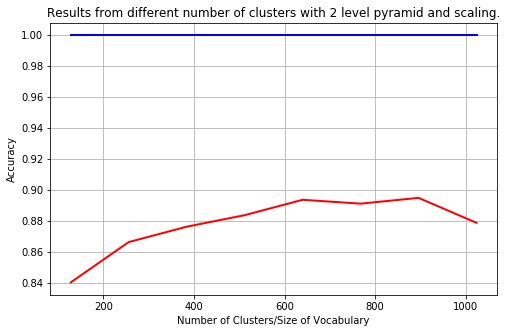

In [13]:
plt.figure(figsize=(8, 5))
plt.title('Results from different number of clusters with 2 level pyramid and scaling.')
plt.plot(N_CLUSTERS,results_train,'b',linewidth=2,label='Test')
plt.plot(N_CLUSTERS,results_test,'r',linewidth=2,label='Train')
plt.ylabel('Accuracy')
plt.xlabel('Number of Clusters/Size of Vocabulary')
plt.grid(True)
plt.show()

We see that as before using 896 clusters seems to work better than using lower number of clusters. At the same time we achieve to get a greater increase of the accuracy reaching the 89.47% a significant improvement from the vanilla SVM with DenseSIFT.

If we compare the results of this experiment with the results obtained before we see that:

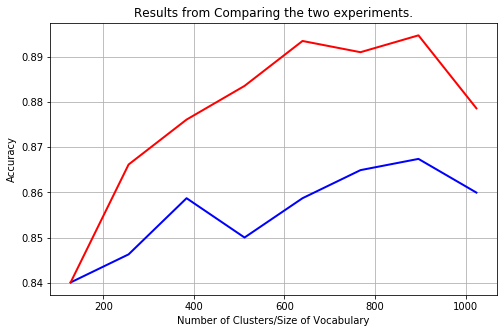

In [9]:
plt.figure(figsize=(8, 5))
plt.title('Results from Comparing the two experiments.')
plt.plot(N_CLUSTERS,results_normal,'b',linewidth=2,label='Normal')
plt.plot(N_CLUSTERS,results_pyramid,'r',linewidth=2,label='Pyramid')
plt.ylabel('Accuracy')
plt.xlabel('Number of Clusters/Size of Vocabulary')
plt.grid(True)
plt.show()

The pyramid outperforms the previous method for any value of clusters, reaching the highest precision at 896 with 89.47% percent. This means that using descriptors that take into account the position work better than if descriptors of the full image are taken.

FISHER
--

We are still very intrigued about if it is possible to reach precisions higher than 90%, that's why we have installed the yael library and tried the fisher vectors. For this reason here there are the correspondance imports using python2 that our code needs to compute the fisher vectors. 

Instead of computing the data using the bag of visual words, many papers suggest that fisher vectors work at state of art precision. Fisher vectors are used a lot in Computer Vision and can be used to describe an entire image for image classification. Are inspired by using Gaussian Mixture Models and approximate the probability density of the data.

1. A Gaussian Mixture Model (GMM) is used to model the distribution of features (e.g. SIFT) extracted all over the image
2. The Fisher Vector (FV) encodes the gradients of the log-likelihood of the features under the GMM, with respect to the GMM parameters.

Since the GMM parameters represent the first-order moments of the features, the FV encodes second-order moments of the features, roughly.

Once we have the fisher vectors ready we will pass them through the SVM with the best parameters found under the "Finetuning SVM" part.

In [1]:
from yael.yael import ynumpy
from utils.DatasetManager import DatasetManager
from utils.Kernels import histogram_intersection_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
import pickle
import os
import numpy as np

In [2]:
train_desc_path = "/home/joan/workspace/MCV_M3/M3_project/SavePath/desc_fisher/train.dat"
test_desc_path = "/home/joan/workspace/MCV_M3/M3_project/SavePath/desc_fisher/test.dat"

In [3]:
train_desc = pickle.load(open(train_desc_path, 'rb'))
test_desc = pickle.load(open(test_desc_path, 'rb'))
all_train_desc = np.vstack(train_desc)

In [4]:
k = 64
n_sample = k * 5000
# choose n_sample descriptors at random
sample_indices = np.random.choice(all_train_desc.shape[0], n_sample)
sample = all_train_desc[sample_indices]
# until now sample was in uint8. Convert to float32
sample = sample.astype('float32')
# until now sample was in uint8. Convert to float32
gmm = ynumpy.gmm_learn(sample, k)

In [5]:
train_fvs = []
for image_desc in train_desc:
    fv = ynumpy.fisher(gmm, image_desc, include = 'mu')
    train_fvs.append(fv)

In [6]:
test_fvs = []
for image_desc in test_desc:
    fv = ynumpy.fisher(gmm, image_desc, include = 'mu')
    test_fvs.append(fv)

In [7]:
train_data = np.array(train_fvs)
test_data = np.array(test_fvs)

In [10]:
K_FOLDS = 5
PARAMETERS = {
    'C': [0.00134],
    'gamma': ["scale"],
    'kernel': [histogram_intersection_kernel]}

cv = GridSearchCV(SVC(), param_grid=PARAMETERS, cv=K_FOLDS, n_jobs=-1, verbose=5)
cv.fit(train_data, train_labels)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.1min remaining: 13.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kernel': [<function histogram_intersection_kernel at 0x7ff82c0d83d0>], 'C': [0.00134], 'gamma': ['scale']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [11]:
train_score = cv.score(train_data, train_labels)
test_score = cv.score(test_data, test_labels)
        
print("Train accuracy score: {}\nTest accuracy score: {}\nBest params: {}\n".format(train_score, test_score, cv.best_params_))
print("All results: {}".format(cv.cv_results_))

Train accuracy score: 0.999468367889
Test accuracy score: 0.877323420074
Best params: {'kernel': <function histogram_intersection_kernel at 0x7ff82c0d83d0>, 'C': 0.00134, 'gamma': 'scale'}

All results: {'std_train_score': array([0.00026587]), 'split4_test_score': array([0.86021505]), 'split0_train_score': array([0.99933422]), 'rank_test_score': array([1], dtype=int32), 'param_gamma': masked_array(data=['scale'],
             mask=[False],
       fill_value='?',
            dtype=object), 'split2_train_score': array([0.99933555]), 'std_score_time': array([1.92198117]), 'split4_train_score': array([0.99933731]), 'split2_test_score': array([0.88297872]), 'mean_score_time': array([52.24375176]), 'mean_fit_time': array([222.23916001]), 'param_kernel': masked_array(data=[<function histogram_intersection_kernel at 0x7ff82c0d83d0>],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_C': masked_array(data=[0.00134],
             mask=[False],
       fill_value=

### Fisher conclusions:


As we can see, results using Fisher vectors are pretty good reaching 87.73% of accuracy but not enough to surpas our best score yet (89.47%). 

However, we think that this result is pretty good compared with the vanilla SVM, which at best, work at 86.5%.

For later studies we propose to finetune the SVM for the Fisher Vectors.

FINAL RESULTS
--

To conclude this notebook, we will expose what have work for us and which model performed better:

1. We have seen that using Pyramid Dense SIFT works best than using vanilla Dense SIFT. Our implementation of Pyramid consist of dividing the image in equal parts and computing the Dense SIFT descriptors on them. 

2. We also consider using more than one scale when computing DenseSIFT as we have proven to be beneficial with scales of 8 and 16 pixels.

3. When using SVM, setting a big number of clusters is beneficial.We think this is due to the fact that with more clusters SVM is able to construct better hyper cylinders or find the dimension where the data is completely separabable.

4. We have seen that normalization can influence the results of the SVM, where the l1 showed better results than other normalization techniques. However, in our case, we noticed a drop in performance when using the vanilla SVM. 

5. When finetuning the SVM, we have study how the different parameters affect the performance of the SVM, concluding that:
    * The regularizer parameter change depending on the kernel used. For sigmoid for example, has to be set with values around 1, but with our implementation of histogram_intersection is better to use values around 1e-3. Setting this value higher produce an underscore and plateau.
    * Linear, Sigmoid and Histogram_Intersection were performing almost the same, with the only difference being that sigmoid seem to not overfit the training data. RBF kernel proven to be the worst kernel.
    * Tolerance value proven to be insignificant, as their effect was negligible as long as it value was lower than 2.
    
    
6. We tried to use Fisher Vectors instead of Bag of Visual Words but we didn't achieve to reach the best score obtained. On the other side, the addition of Fisher Vectors improved our results using the vanilla finetuned SVM by 1% (FinetunedSVM: 86,74%, Fisher-Vectors: 87,73%)

Overall we have seen that SVM outperforms KNN (from 81.5% to 89.47%) and we want to highlight that improvement obtained from the finetuning was slighter than the one obtained by modifying the data (using Pyramid DenseSIFT, adding more scales to the SIFT descriptors, normalizing it and scaling it), as we passed from 86.7% to 87.67 finetuning the SVM while passing from 86.7% to 89.47 just changing the DenseSIFT to Pyramid DenseSIFT.

The best model was obtained using:

* Pyramid DenseSIFT dividing the image by 4 parts and using steps of 16 pixels and scales of 8 and 16.
* Using 896 clusters
* Scaling the data
* Using the Histogram Intersection
* Setting regularizer parameter (C) to 0.00134

With this setting we obtained our best with 89.47% (Pyramid DenseSIFT graph)